## DNN modeling

In [17]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import pandas as pd
from torch.utils.data import Dataset

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

class TitaticDataset(Dataset):
    def __init__(self):
        df = pd.read_csv('../dataset/train_preprocessed.csv')
        
        self.data = scaler.fit_transform(df.drop('Survived',axis=1))
        self.labels = df['Survived']

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        X = torch.tensor(self.data[idx], dtype=torch.float32)  # 입력값 텐서 변환
        y = torch.tensor(self.labels[idx], dtype=torch.float32)  # 레이블 텐서 변환
        return X,y

In [58]:
trainDataset = TitaticDataset()

In [59]:
train_len = int(len(trainDataset) * 0.8)
valid_len = len(trainDataset) - train_len

# dataset 객체를 유지해줌 / treain_test_split은 dataset 객체에 사용이 안된다.
train_data, valid_data = torch.utils.data.random_split(trainDataset, [train_len, valid_len])

In [62]:
train_dataloader = DataLoader(train_data,batch_size=32,shuffle=True)
valid_dataloader = DataLoader(valid_data,batch_size=32,shuffle=False)

In [136]:
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.fc_layer = nn.Sequential(
            nn.Linear(22,128),
            nn.Sigmoid(),
            nn.Linear(128,64),
            nn.Sigmoid(),
            nn.Linear(64,32),
            nn.Sigmoid(),
            nn.Linear(32,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.fc_layer(x)

In [179]:
model = NN()

In [180]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [181]:
train_hist = []
valid_hist = []
acc = []

In [188]:
import tqdm
tbar = tqdm.tqdm(train_dataloader)
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    model.train()
    loss = 0

    for i,(X,y) in enumerate(tbar):
        y_perd = model(X)
        Loss = loss_fn(y_perd,y.reshape(-1,1))
        Loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss += Loss.item()
        tbar.set_description(f'Loss: {Loss.item()}')
        
    loss /= len(train_dataloader)
    train_hist.append(loss)

    model.eval()
    val_loss,correct = 0,0
    sample_size = len(valid_dataloader.dataset)
    batch_size = len(valid_dataloader)
    with torch.no_grad():
        for X,y in valid_dataloader:
            y_perd = model(X)
            Loss = loss_fn(y_perd,y.reshape(-1,1))
            val_loss += Loss.item()
            correct += ((y_perd > 0.5) == y.reshape(-1,1)).type(torch.float).sum().item()
        val_loss /= batch_size
        accuracy = correct / sample_size
        acc.append(accuracy)
        print(f'Valid Error : val_Loss: {val_loss} accuracy: {accuracy}')
        valid_hist.append(val_loss)

Loss: 0.33713850378990173:  39%|███▉      | 9/23 [00:00<00:00, 84.89it/s]

Epoch 1
-------------------------------


Loss: 0.11691243201494217: 100%|██████████| 23/23 [00:00<00:00, 121.19it/s]


Valid Error : val_Loss: 0.425334374109904 accuracy: 0.8212290502793296
Epoch 2
-------------------------------
Valid Error : val_Loss: 0.4271574318408966 accuracy: 0.8268156424581006
Epoch 3
-------------------------------
Valid Error : val_Loss: 0.42531177898248035 accuracy: 0.8156424581005587
Epoch 4
-------------------------------
Valid Error : val_Loss: 0.42528416713078815 accuracy: 0.8212290502793296
Epoch 5
-------------------------------
Valid Error : val_Loss: 0.422235185901324 accuracy: 0.8212290502793296
Epoch 6
-------------------------------
Valid Error : val_Loss: 0.42852312823136646 accuracy: 0.8156424581005587
Epoch 7
-------------------------------
Valid Error : val_Loss: 0.4259461462497711 accuracy: 0.8156424581005587
Epoch 8
-------------------------------
Valid Error : val_Loss: 0.4304785182078679 accuracy: 0.8324022346368715
Epoch 9
-------------------------------
Valid Error : val_Loss: 0.4223109583059947 accuracy: 0.8212290502793296
Epoch 10
----------------------

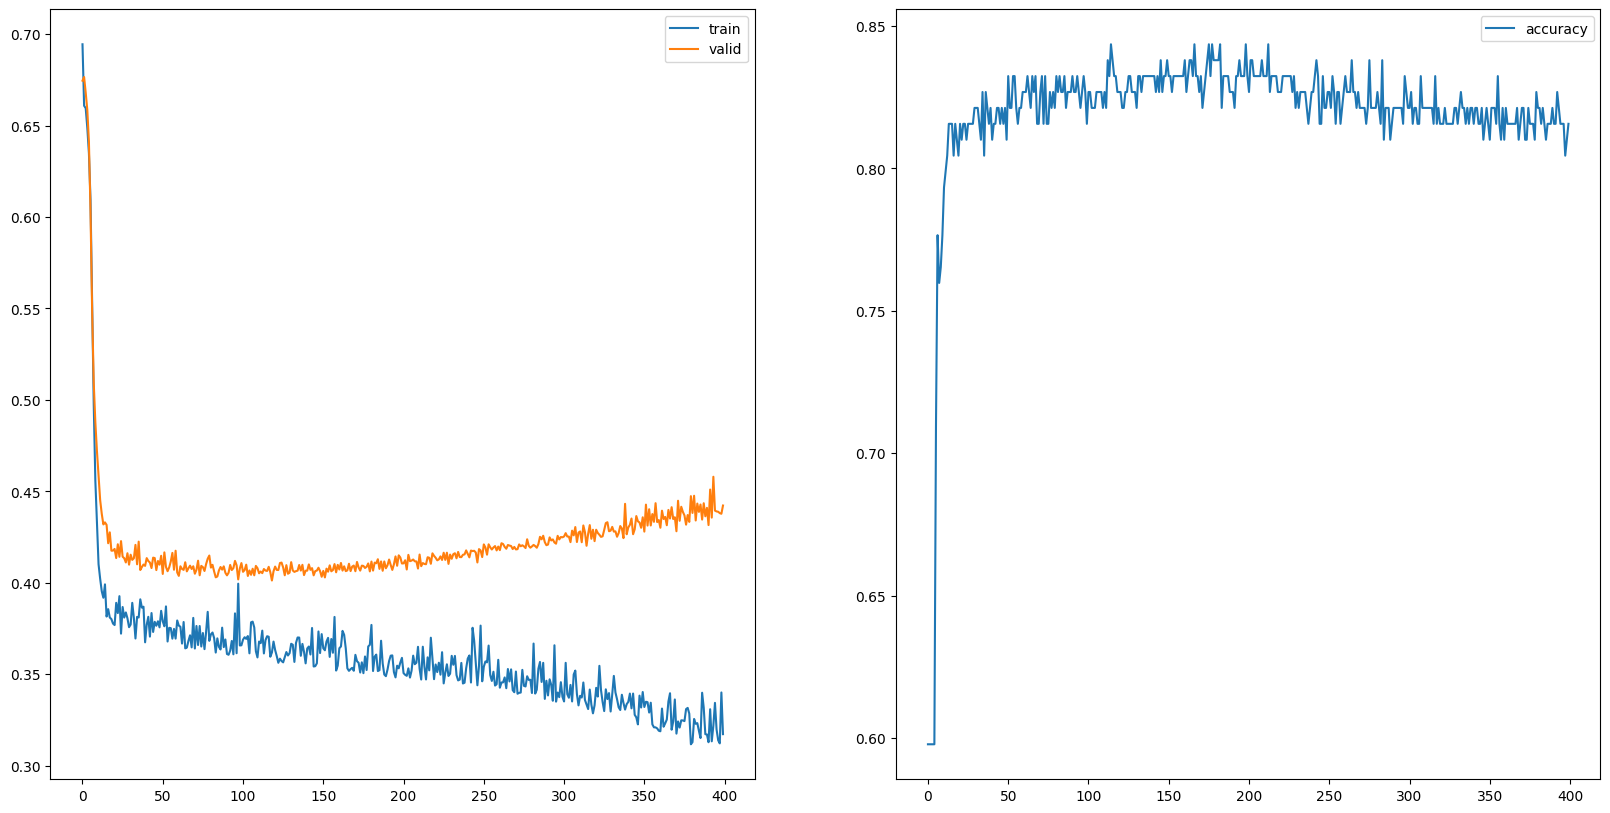

In [189]:
import matplotlib.pyplot as plt
f,a = plt.subplots(1,2,figsize = (20,10))
a[0].plot(train_hist,label='train')
a[0].plot(valid_hist,label='valid')
a[0].legend()
a[1].plot(acc,label='accuracy')
a[1].legend()
